In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from joblib import dump
import json
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc
import time

In [2]:
# Load the dataset
file_path = "Train_data.csv"
df = pd.read_csv(file_path)

# Perform basic checks: head, tail, info, shape
head = df.head()
tail = df.tail()
info = df.info()
shape = df.shape

(head, tail, shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

(   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
 0         0           tcp  ftp_data   SF        491          0     0   
 1         0           udp     other   SF        146          0     0   
 2         0           tcp   private   S0          0          0     0   
 3         0           tcp      http   SF        232       8153     0   
 4         0           tcp      http   SF        199        420     0   
 
    wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
 0               0       0    0  ...                  25   
 1               0       0    0  ...                   1   
 2               0       0    0  ...                  26   
 3               0       0    0  ...                 255   
 4               0       0    0  ...                 255   
 
    dst_host_same_srv_rate  dst_host_diff_srv_rate  \
 0                    0.17                    0.03   
 1                    0.00                    0.60   
 2                    0.10          

In [3]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Check if any duplicates exist
duplicate_count = df.duplicated().sum()

print("Null values per column:\n", null_counts)
print("\nTotal duplicate rows:", duplicate_count)

Null values per column:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate     

In [4]:
# Identify categorical columns (dtype == object)
categorical_cols = df.select_dtypes(include=['object']).columns

# Check unique values for each categorical column
for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].unique())
    print("\n")

Column: protocol_type
['tcp' 'udp' 'icmp']


Column: service
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']


Column: flag
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']


Column: class
['normal' 'anomaly']




In [5]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound))

# Apply the function to all numeric columns
outliers = numeric_cols.apply(detect_outliers_iqr)

# Count total outliers
total_outliers = outliers.sum().sum()

# Percentage of outliers in dataset
total_cells = np.prod(numeric_cols.shape)   # fixed here
outlier_percentage = (total_outliers / total_cells) * 100

print(f"Total outliers: {total_outliers}")
print(f"Percentage of outliers in dataset: {outlier_percentage:.2f}%")

Total outliers: 45479
Percentage of outliers in dataset: 4.75%


/tmp/ipython-input-154761998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="class", palette="viridis")


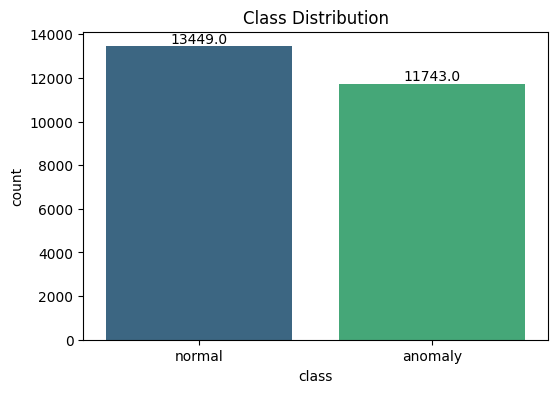

In [6]:
# 1) Bar chart: Count of normal vs anomaly classes
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="class", palette="viridis")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title("Class Distribution")
plt.show()

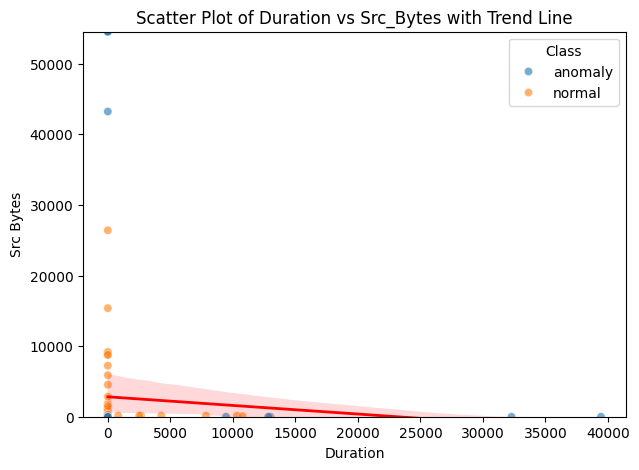

In [7]:
# 2. Scatter plot with trend line added using regression fit
plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=df.sample(500, random_state=42),
                     x="duration", y="src_bytes", hue="class", alpha=0.6)

# Add regression trend line (lowess for smooth curve)
sns.regplot(data=df.sample(500, random_state=42),
            x="duration", y="src_bytes", scatter=False,
            line_kws={"color":"red","lw":2}, ax=ax)

plt.title("Scatter Plot of Duration vs Src_Bytes with Trend Line")
plt.xlabel("Duration")
plt.ylabel("Src Bytes")
plt.ylim(df['src_bytes'].quantile(0.01), df['src_bytes'].quantile(0.99))  # limit extreme outliers for view
plt.legend(title="Class")
plt.show()

/tmp/ipython-input-1629894968.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x="class", y="src_bytes", palette="Set2")


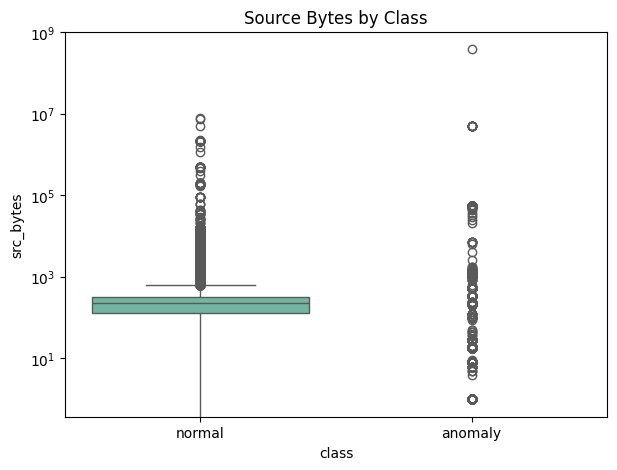

In [8]:
# 3) Boxplot: src_bytes grouped by class with values overlay
plt.figure(figsize=(7,5))
ax = sns.boxplot(data=df, x="class", y="src_bytes", palette="Set2")
plt.title("Source Bytes by Class")
plt.yscale("log")  # log scale to better visualize skew
plt.show()

In [9]:
# List of categorical columns to encode
categorical_cols = ["protocol_type", "service", "flag"]

# Apply LabelEncoder to each
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Verify the transformation
for col in categorical_cols:
    print(f"\nUnique values in {col} after encoding: {df[col].unique()}")


Unique values in protocol_type after encoding: [1 2 0]

Unique values in service after encoding: [19 41 46 22 48 33 35 13 32 57 17 11 55 63  2 51  6 62 34 61  3 10 18  4
 29 14 20 64 56 23 15 65 25 26 12 27 30 54 31 28 52 59 21 16 40  9 39  5
  7 53  8 50 37 44 38  0 43 45 58 42 47 36 49  1 60 24]

Unique values in flag after encoding: [ 9  5  1  4 10  2  6  3  8  7  0]


In [10]:
# Map 'normal' -> 0, 'anomaly' -> 1
class_mapping = {
    "normal": 0,
    "anomaly": 1
}

# Apply mapping in place
df["class"] = df["class"].map(class_mapping)

# Verify
print(df["class"].unique())

[0 1]


In [11]:
# Separate features and target
X = df.drop(columns=["class"])
y = df["class"]

# Compute Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)

# Store results in DataFrame
mi_df = pd.DataFrame({"Feature": X.columns, "MI_Score": mi_scores})
mi_df = mi_df.sort_values(by="MI_Score", ascending=False).reset_index(drop=True)

mi_df

,Feature,MI_Score
0,src_bytes,0.563968
1,service,0.469105
2,dst_bytes,0.435049
3,flag,0.365498
4,diff_srv_rate,0.360945
5,same_srv_rate,0.356138
6,dst_host_srv_count,0.324972
7,dst_host_same_srv_rate,0.308920
8,dst_host_diff_srv_rate,0.288429
9,dst_host_serror_rate,0.282014


In [12]:
# X = all features except the target column
X = df.drop(columns=["class"])

# y = target column
y = df["class"]

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((20153, 41), (5039, 41), (20153,), (5039,))


MODEL: Random Forest

Classification Report:
              precision    recall  f1-score   support

      normal      0.995     0.999     0.997      2690
     anomaly      0.999     0.994     0.997      2349

    accuracy                          0.997      5039
   macro avg      0.997     0.997     0.997      5039
weighted avg      0.997     0.997     0.997      5039



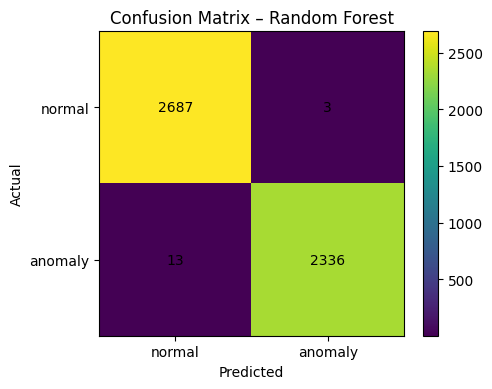

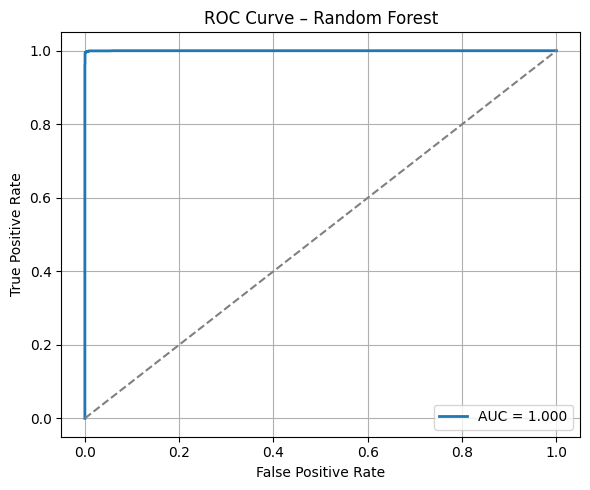


MODEL: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

      normal      0.996     0.999     0.998      2690
     anomaly      0.999     0.996     0.997      2349

    accuracy                          0.997      5039
   macro avg      0.998     0.997     0.997      5039
weighted avg      0.997     0.997     0.997      5039



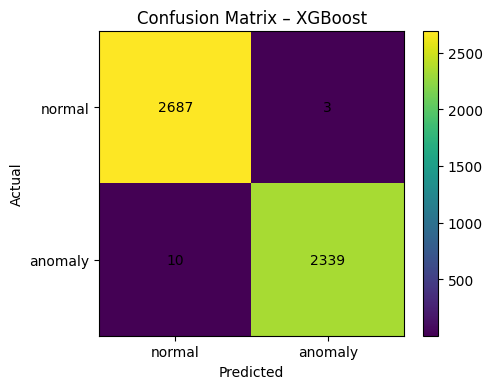

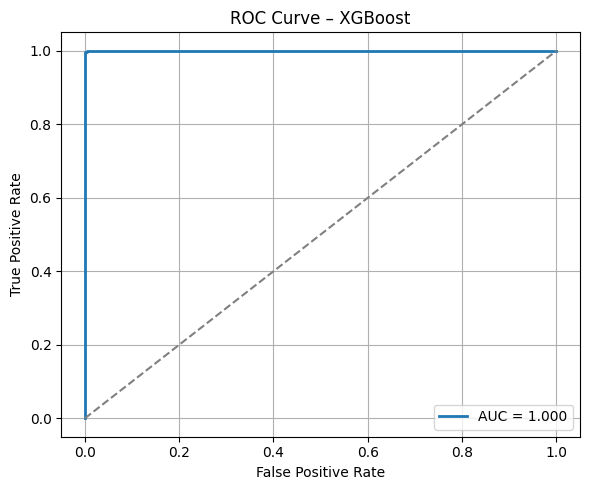


MODEL: SVM (RBF)

Classification Report:
              precision    recall  f1-score   support

      normal      0.991     0.989     0.990      2690
     anomaly      0.987     0.989     0.988      2349

    accuracy                          0.989      5039
   macro avg      0.989     0.989     0.989      5039
weighted avg      0.989     0.989     0.989      5039



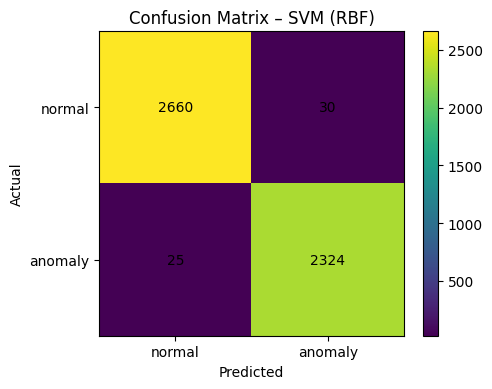

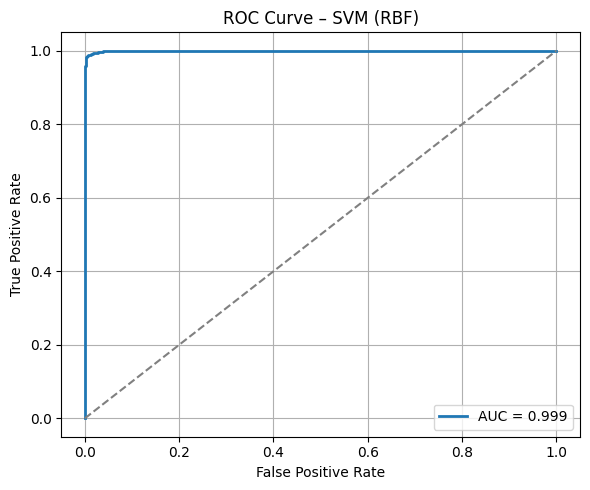


MODEL: K-Nearest Neighbours

Classification Report:
              precision    recall  f1-score   support

      normal      0.992     0.993     0.993      2690
     anomaly      0.992     0.991     0.991      2349

    accuracy                          0.992      5039
   macro avg      0.992     0.992     0.992      5039
weighted avg      0.992     0.992     0.992      5039



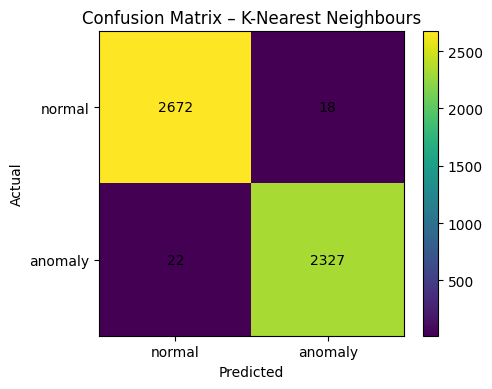

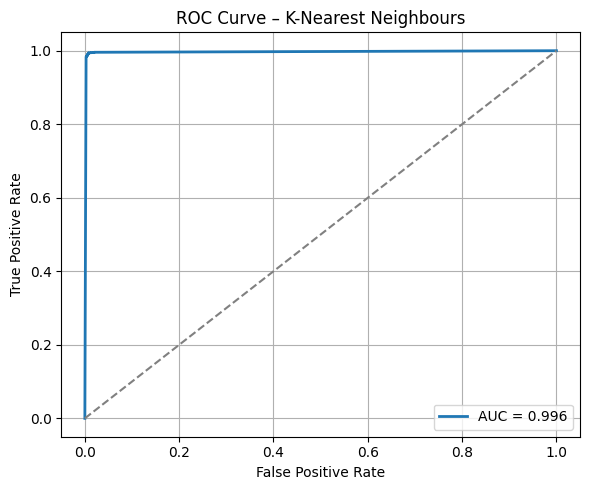


MODEL: Neural Network (MLP)

Classification Report:
              precision    recall  f1-score   support

      normal      0.990     0.994     0.992      2690
     anomaly      0.993     0.989     0.991      2349

    accuracy                          0.992      5039
   macro avg      0.992     0.991     0.992      5039
weighted avg      0.992     0.992     0.992      5039



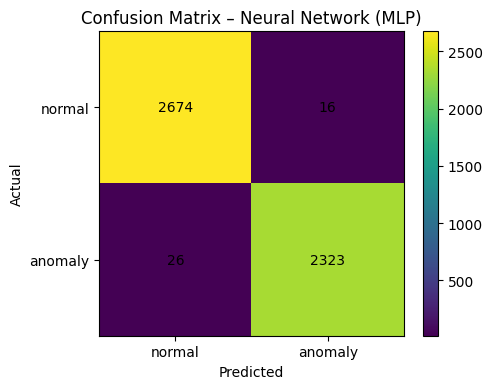

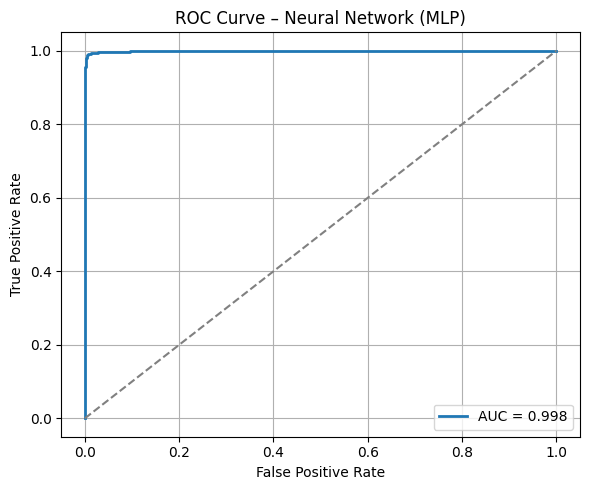

In [13]:
# FULL MODEL-BY-MODEL EVALUATION PIPELINE


import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report,
    roc_curve, auc
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Evaluation Function

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    return {
        "Model": name,
        "Accuracy %": round(acc * 100, 2),
        "Precision (Macro) %": round(prec * 100, 2),
        "Recall (Macro) %": round(rec * 100, 2),
        "F1 (Macro) %": round(f1 * 100, 2),
        "Anomaly FPR %": round(fpr * 100, 2)
    }, y_pred

# MODELS

models = [
    ("Random Forest",
     Pipeline([("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])),

    ("XGBoost",
     Pipeline([("clf", XGBClassifier(
         n_estimators=400, max_depth=6, learning_rate=0.1,
         subsample=0.9, colsample_bytree=0.9,
         random_state=42, n_jobs=-1,
         eval_metric="logloss", use_label_encoder=False
     ))])),

    ("SVM (RBF)",
     Pipeline([("scaler", StandardScaler()),
               ("clf", SVC(C=3.0, kernel="rbf", gamma="scale", probability=True))])),

    ("K-Nearest Neighbours",
     Pipeline([("scaler", StandardScaler()),
               ("clf", KNeighborsClassifier(n_neighbors=7, weights="distance"))])),

    ("Neural Network (MLP)",
     Pipeline([("scaler", StandardScaler()),
               ("clf", MLPClassifier(hidden_layer_sizes=(128,64),
                                     max_iter=300, early_stopping=True,
                                     random_state=42))]))
]

# TRAIN + EVALUATE EACH MODEL

results = []
fitted_models = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:

    print("\n" + "="*70)
    print(f"MODEL: {name}")
    print("="*70)

    # -----------------------------
    # Training
    # -----------------------------
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # -----------------------------
    # Prediction
    # -----------------------------
    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred

    # -----------------------------
    # Metrics
    # -----------------------------
    metrics, _ = evaluate_model(name, model, X_test, y_test)

    cv_auc = cross_val_score(
        model, X, y,
        cv=cv, scoring="roc_auc", n_jobs=-1
    )

    metrics["Mean ROC-AUC"] = round(cv_auc.mean(), 4)
    metrics["Train Time (s)"] = round(train_time, 3)
    metrics["Prediction Time (s)"] = round(pred_time, 3)

    results.append(metrics)
    fitted_models[name] = model


    # CLASSIFICATION REPORT

    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=["normal", "anomaly"],
        digits=3
    ))


    # CONFUSION MATRIX

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="viridis")
    plt.title(f"Confusion Matrix – {name}")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.xticks([0,1], ["normal", "anomaly"])
    plt.yticks([0,1], ["normal", "anomaly"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


    # ROC CURVE

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
fitted_models = {}   # store fitted pipelines
results = []
pred_by_model = []
timing_info = []

for name, pipe in models:
    # ------------------------
    # Training
    # ------------------------
    start_train = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_train

    # ------------------------
    # Prediction
    # ------------------------
    start_pred = time.time()
    y_pred = pipe.predict(X_test)
    pred_time = time.time() - start_pred

    # ------------------------
    # Core metrics
    # ------------------------
    row, _ = evaluate_model(name, pipe, X_test, y_test)

    # ------------------------
    # Cross-validated ROC-AUC
    # ------------------------
    cv_auc = cross_val_score(
        pipe, X, y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    row["Mean ROC-AUC"] = round(cv_auc.mean(), 4)
    row["Train Time (s)"] = round(train_time, 3)
    row["Prediction Time (s)"] = round(pred_time, 3)

    results.append(row)
    fitted_models[name] = pipe

# =========================
# Results Table
# =========================
metrics_df = pd.DataFrame(results)

print("\n=== Model Metrics (Binary Classification) ===")
print(metrics_df.to_string(index=False))

# =========================
# Convert % columns for ranking
# =========================
num_cols = [
    "Accuracy %", "Precision (Macro) %",
    "Recall (Macro) %", "F1 (Macro) %",
    "Anomaly FPR %"
]

metrics_num = metrics_df.copy()
for col in num_cols:
    metrics_num[col] = metrics_num[col].astype(str).str.rstrip("%").astype(float)

# =========================
# Model Selection Logic
# =========================
# Primary constraints:
# Accuracy ≥ 95%
# Anomaly FPR ≤ 5%

eligible = metrics_num[
    (metrics_num["Accuracy %"] >= 95.0) &
    (metrics_num["Anomaly FPR %"] <= 5.0)
]

# Rank by: F1 → ROC-AUC → Training Time
if not eligible.empty:
    best_row = (
        eligible.sort_values(
            by=["F1 (Macro) %", "Mean ROC-AUC", "Train Time (s)"],
            ascending=[False, False, True]
        ).iloc[0]
    )
else:
    best_row = (
        metrics_num.sort_values(
            by=["F1 (Macro) %", "Mean ROC-AUC", "Train Time (s)"],
            ascending=[False, False, True]
        ).iloc[0]
    )

best_model_name = best_row["Model"]
best_model = fitted_models[best_model_name]

# =========================
# Final Output
# =========================
print("\n>>> Best Fitted Model Selected:")
print(best_model_name)

print(best_row[
    ["Accuracy %", "Precision (Macro) %", "Recall (Macro) %",
     "F1 (Macro) %", "Mean ROC-AUC",
     "Anomaly FPR %", "Train Time (s)", "Prediction Time (s)"]
])

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:39:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Model Metrics (Binary Classification) ===
               Model  Accuracy %  Precision (Macro) %  Recall (Macro) %  F1 (Macro) %  Anomaly FPR %  Mean ROC-AUC  Train Time (s)  Prediction Time (s)
       Random Forest       99.68                99.70             99.67         99.68           0.11        1.0000           4.704                0.131
             XGBoost       99.74                99.75             99.73         99.74           0.11        0.9999           1.375                0.050
           SVM (RBF)       98.91                98.90             98.91         98.90           1.12        0.9991          10.810                0.380
K-Nearest Neighbours       99.21                99.21             99.20         99.20           0.67        0.9980           0.018                0.977
Neural Network (MLP)       99.17                99.18             99.15         99.16           0.59        0.9993           4.555                0.014

>>> Best Fitted Model Selected:
XGBoost


In [15]:
# 1) Save the fitted pipeline
dump(best_model, "model.joblib")

# 2) Save feature order (critical for correct inference)
feature_names = X.columns.tolist()
with open("feature_names.json", "w") as f:
    json.dump(feature_names, f, indent=2)

# 3) Save label mapping info (binary: normal=0, anomaly=1)
label_mapping = {"normal": 0, "anomaly": 1}
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f, indent=2)

print("Saved: model.joblib, feature_names.json, label_mapping.json")

Saved: model.joblib, feature_names.json, label_mapping.json


In [16]:
# save_cat_encoders.py
categorical_cols = ["protocol_type", "service", "flag"]

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))  # ensure strings
    classes = list(le.classes_)
    mapping = {cls: int(le.transform([cls])[0]) for cls in classes}
    encoders[col] = mapping

with open("cat_encoders.json", "w") as f:
    json.dump(encoders, f, indent=2)

print("Saved cat_encoders.json with mappings for:", list(encoders.keys()))

Saved cat_encoders.json with mappings for: ['protocol_type', 'service', 'flag']
